<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [91]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# naive_bayes classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# based_ruled
import wittgenstein as lw

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Global parameters </h6>

In [92]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = lw.RIPPER(random_state=42, verbosity=0)  
model_name = "RIPPER"  

learning_curve_flag = False
v_or_t_flag = "TST"
cmap = plt.cm.spring_r
color = "fuchsia"

<h6> Datasets loading </h6>

In [93]:
X_train = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train_vt = pd.read_csv('../../data/fma_metadata/X_train_merged_vt.csv', index_col=0)
X_test_vt = pd.read_csv('../../data/fma_metadata/X_test_vt.csv', index_col=0)

print(X_train_vt.shape, X_test_vt.shape)
print(y_train.shape, y_test.shape)

(92834, 55) (10874, 55)
(92834, 1) (10874, 1)
(92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6>Continous, categorical/ordinal column retrieval</h6>

In [94]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [95]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


In [96]:
numeric_columns_vt = list(set(numeric_columns).intersection(set(X_train_vt.columns)))
print("numeric_columns_vt", len(numeric_columns_vt))

numeric_columns_vt 15


In [97]:
categoric_columns_vt = list(set(categoric_columns).intersection(set(X_train_vt.columns)))
print("categoric_columns_vt", len(categoric_columns_vt))

categoric_columns_vt 13


<h6>Define current (filtered) train and test</h6>

In [98]:
X_tr = X_train.copy()
y_tr = y_train.copy()
X_ts = X_test.copy()
y_ts = y_test.copy()

X_tr_vt = X_train_vt.copy()
X_ts_vt = X_test_vt.copy()

print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 55) (10874, 55) (92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h2> RIPPER </h2>

**Default parameters**:
- max_total_conds=None, 
- prune_size=0.33, # change the grow/prune proportion
- dl_allowance=64, # the complexity stopping threshold
- k=2, # the complexity stopping threshold
- n_discretize_bins=10, 
- max_rule_conds=None, 
- max_rules=None, 
- random_state=None, 
- verbosity=0

**Tuned parameters**:
- random_state=42
- n_discretize_bins=list(range(1, 11))
- prune_size=list(np.arange(0.1, 1.1, 0.1)
- k=[1, 2]

In [56]:
def model_grid(X_tr):
    grid = dict()
    grid['model__n_discretize_bins'] = list(range(1, 11))
    grid['model__prune_size'] = list(np.arange(0.1, 1.1, 0.1))
    grid['model__k'] = [1, 2]
    return grid

In [57]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name, v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    try:
        pca = PCA(n_components=2)
        best_visualisation_scaler = StandardScaler()
        scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
        X = pca.fit_transform(scaled_X_tr)
        # X = pca.fit_transform(X_tr)
        y = y_tr.values.ravel()

        model.fit(X, y)
        plt.figure(figsize=(8, 5))
        fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
        plt.legend(loc='best')
        plt.grid(False)
        plt.show()
    except ValueError:
        return

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()
    
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                        random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

In [58]:
def get_best_features_grid_cv(X_tr, y_tr, results, key):
    
    if key == 'anova':
        best_k = results.best_params_['anova__k']
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe':
        best_k = results.best_params_['rfe__n_features_to_select']
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance using %s" % (model_name, v_or_t_flag,  key.upper()))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [59]:
def get_feature_importances_or_coef(X_tr, y_tr, tuned_model):

    try:
        df_scores = pd.DataFrame(tuned_model.feature_importances_)
        best_k = tuned_model.n_features_
    except:
        try:
            df_scores = pd.DataFrame(tuned_model.coef_)

            best_k = len([x for x in list(df_scores.values)])
        except:
            print("Wrong curr_model's retrieval feature importance")
            sys.exit(-1)

    df_columns = pd.DataFrame(X_tr.columns)   
    feature_scores = pd.concat([df_columns, df_scores], axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.grid(False)
    plt.title("%s's %s feature importance" % (model_name, v_or_t_flag))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)


    return best_features, best_features_scores

In [60]:
def replace_categorical_feature_with_dummy_ones(df, column_name, categories_list, dummy_features):
    """
    Function which replaces the nominal feature passed by argument with dummy ones, 
    to convert nominal column's M values in M new binary (dummy) features.
    """
    # retrive nominal feature's index. It is used to know where to insert the new M binary features
    index = df.columns.get_loc(column_name)
    for i in range(0, dummy_features.shape[1]):
        index += 1
        df.insert(index, column_name + "_" + str(categories_list[i]), 
                                                              dummy_features[:, i].todense().astype(int), True)
    # remove categorical feature
    del df[column_name]
    
    return df

In [61]:
def get_tuned_model(X_tr, y_tr, params, numeric_features):
    
    X_tr_curr = X_tr.copy()
    
    model_params = list(model_grid(X_tr_curr).keys())
    try:
        n_bins = params['preprocessor__numeric__discretizer__n_bins'] 
        strategy = params['preprocessor__numeric__discretizer__strategy']
        encode = params['preprocessor__numeric__discretizer__encode']
        discretizer = KBinsDiscretizer(encode=encode, n_bins=n_bins, strategy=strategy)
        # scale data
        X_tr_curr = discretizer.fit_transform(X_tr_curr.values)
        
        # need to onehot continous and ordinal features
        ordinal_columns = ['track_date_created_season', 'track_date_created_year'] 
        numeric_features = numeric_features + ordinal_columns
        for column_name in numeric_features:
            try:
                categories_list = sorted(list(X_tr_curr[column_name].unique()))
                encoder = OneHotEncoder(categories=[categories_list])   
                dummy_features = encoder.fit_transform(X_tr_curr[column_name].values.reshape(-1,1))  
                X_tr_curr = replace_categorical_feature_with_dummy_ones(X_tr_curr, column_name, categories_list, dummy_features)
            except:
                continue
    except KeyError:
        pass


    try:
        scaler = params['preprocessor__numeric__discretizer__scaler']
        # scale data
        X_tr_curr = scaler.fit_transform(X_tr_curr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr_curr, y_tr.values.ravel())
    
    plot_decision_boundary(X_tr_curr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    
    if learning_curve_flag:
        plot_learning_curve(curr_X_tr_vt, y_tr, tuned_model, v_or_t_flag)
    
    return tuned_model

In [64]:
def grid_search(X_tr, y_tr, X_ts, y_ts, numeric_features, categorical_features, discretizer_flag, 
                                                            scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    # scaler = RobustScaler()
    grid=model_grid(X_tr)
    steps = [('model', model)]
        
    if feature_filter_key == 'anova':
        anova = SelectKBest(score_func=f_classif)
        steps.insert(0, ('anova', anova))
        grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    elif feature_filter_key == 'rfe':
        rfe = RFE(estimator=DecisionTreeClassifier())
        steps.insert(0, ('rfe', rfe))
        grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
        grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    # construct feature type's column transformer
    numeric_steps = []
    if scaler_flag:      # continous variable normalisation/standardisation
        numeric_steps.insert(0, ('scaler', None))
        grid['preprocessor__numeric__scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
        
    ordinal_features = None
    ordinal_transformer = None
    if discretizer_flag:  # continous variable binning
        numeric_steps.insert(0, ('discretizer', KBinsDiscretizer(encode='ordinal')))  # ordinal bins
        grid['preprocessor__numeric__discretizer__n_bins'] = list(range(2, 11))
        grid['preprocessor__numeric__discretizer__strategy'] = ['uniform', 'quantile', 'kmeans']
        
        # onehot continous, discretized features
        numeric_steps.append(OneHotEncoder())
        
        # onehot ordinal features
        ordinal_features = ["track_date_created_year", "track_date_created_season"]
        ordinal_transformer = OneHotEncoder()                 
        
    numeric_transformer = None
    if len(numeric_steps) > 0:
        numeric_transformer = Pipeline(steps=numeric_steps)
        preprocessor = ColumnTransformer(
        transformers=[('numeric', numeric_transformer, numeric_features),
                      ('ordinal', ordinal_transformer, ordinal_features)])
        # add numeric ColumnTransformer to global Pipeline
        steps.insert(0, ('preprocessor', preprocessor))
        
    # define the pipeline to evaluate
    pipeline = Pipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted',  cv=cv, verbose=1)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring,  
                                n_iter=n_iter, cv=cv, verbose=1, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    # perform classification (linear model doesn't predict an integer value => no predict_proba)
    y_pred = search.predict(X_ts)
    y_prob = search.predict_proba(X_ts)
    
    # performance plots
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, results.classes_, True)
    plot_classification_report(y_ts, y_pred)
    
    plot_roc_curve(y_ts, y_prob)
    plot_precision_recall_curve(y_ts, y_prob)
    plot_cumulative_gain_curve(y_ts, y_prob)
    plot_lift_curve_curve(y_ts, y_prob)
    
    best_features, best_features_scores = [], []
    if feature_filter_key != "":
        best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, results, feature_filter_key)
        X_tr = X_tr[best_features]
    
    # retrieve the tuned model
    # tuned_model = get_tuned_model(X_tr, y_tr, params, numeric_features)
    tuned_model = pipeline['model']
    if tuned_model !=  pipeline['model']:
        print("Difference in tuned model and pipeline")
        print("tuned_model", tuned_model)
        print("pipe", pipeline['model'])
        # print("estimator", results.estimator)
        sys.exit(-1)
    
    # plots
    if feature_flag and (feature_filter_key == ""):
        best_features, best_features_scores = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
    elif (feature_flag) and (feature_filter_key != ""):
        _ , _ = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
    
    plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    plot_learning_curve(X_tr, y_tr, tuned_model)
    # error_visualizer(not_scale_X_ts, y_ts, y_pred, 'chroma_cens_02', 'track_duration')
    
    return params, tuned_model, y_pred, y_prob, best_features, best_features_scores

Fitting 3 folds for each of 10 candidates, totalling 30 fits


ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

Best Mean F1_weighted: 0.858 
Best Config: {'model__prune_size': 0.1, 'model__n_discretize_bins': 4, 'model__k': 1} 


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [806, 848, 906, 922, 923, 1029, 1222, 1245, 1677, 1961, 1997, 2018, 2228, 2235, 2523, 2933, 2938, 2944, 3052, 3252, 3281, 3285, 3296, 3611, 3614, 4013, 4501, 4504, 4578, 4670, 4884, 5246, 5452, 5467, 5925, 5930, 6319, 7547, 10497, 10567, 10599]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



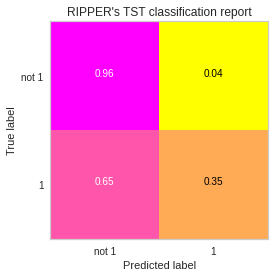

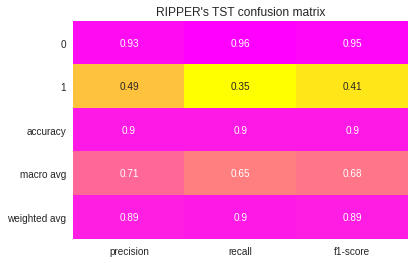

<Figure size 576x360 with 0 Axes>

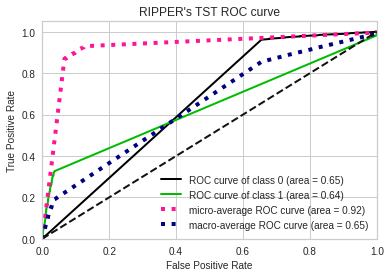

<Figure size 576x360 with 0 Axes>

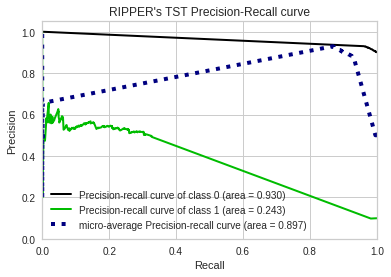

<Figure size 576x360 with 0 Axes>

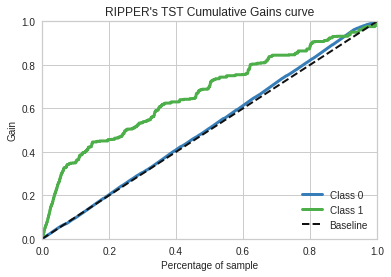

<Figure size 576x360 with 0 Axes>

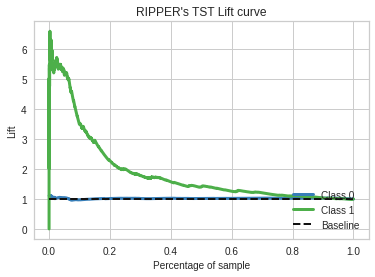

AttributeError: 'list' object has no attribute 'reshape'

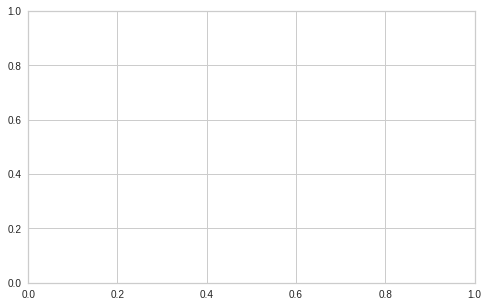

In [65]:
params_tst, tuned_model_tst, y_pred_tst, y_prob_tst, best_features, best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=numeric_columns, 
                                                                categorical_features=categoric_columns, 
                                                                discretizer_flag=False,
                                                                scaler_flag=False, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

<h2> By hand model</h2>

In [113]:
X_tr = X_train.copy()
y_tr = y_train.copy()
X_ts = X_test.copy()
y_ts = y_test.copy()

X_tr_vt = X_train_vt.copy()
X_ts_vt = X_test_vt.copy()

print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 55) (10874, 55) (92834, 28) (10874, 28)
(92834, 1) (10874, 1)


In [114]:
model = lw.RIPPER(random_state=42, verbosity=0, prune_size=0.1, n_discretize_bins=4, k=1)  
results = model.fit(X_tr, y_tr.values.ravel())
y_pred = model.predict(X_ts)
y_prob = model.predict_proba(X_ts)

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [806, 848, 906, 922, 923, 1029, 1222, 1245, 1677, 1961, 1997, 2018, 2228, 2235, 2523, 2933, 2938, 2944, 3052, 3252, 3281, 3285, 3296, 3611, 3614, 4013, 4501, 4504, 4578, 4670, 4884, 5246, 5452, 5467, 5925, 5930, 6319, 7547, 10497, 10567, 10599]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



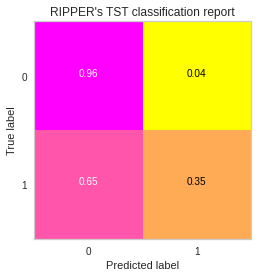

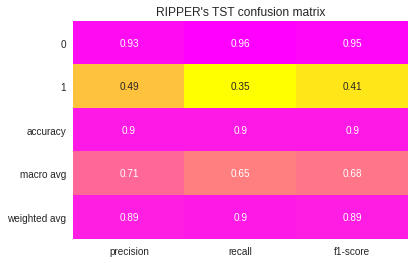

In [115]:
# performance plots
cm = confusion_matrix(y_ts, y_pred)
plot_confusion_matrix(cm, [0, 1], True)
plot_classification_report(y_ts, y_pred)

<Figure size 576x360 with 0 Axes>

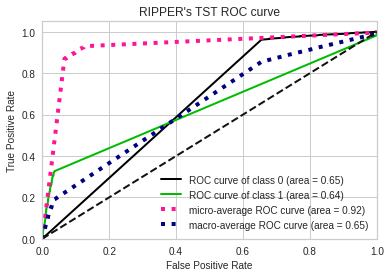

<Figure size 576x360 with 0 Axes>

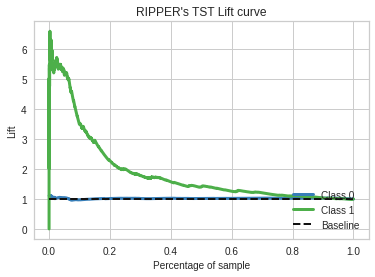

In [116]:
plot_roc_curve(y_ts, y_prob)
plot_lift_curve_curve(y_ts, y_prob)

In [112]:
# plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), model)  # passing random scaler

In [111]:
# plot_learning_curve(X_tr, y_tr, model, v_or_t_flag)

<h6>Rules lookup</h6>

In [123]:
rules = model.ruleset_

In [124]:
import pickle

with open('pickle/' + model_name + '_rules.pickle', 'wb') as handle:
    pickle.dump(rules, handle, protocol=pickle.HIGHEST_PROTOCOL)

<h2> By hand model with ordinal genres</h2>

In [99]:
# reunite together track_genre_top and make it ordinal
genres_columns = [x for x in X_train.columns if "genre_top" in x]

i = 1
genres_map = {}
for column_name in genres_columns:
    genres_map[column_name] = i
    i += 1
    
ordinal_genre_top_column_tr = []
for row_idx in X_train.index:
    for column_name in genres_columns:
        if X_train.at[row_idx, column_name] == 1:
            ordinal_genre_top_column_tr.append(genres_map[column_name])
            
ordinal_genre_top_column_ts = []
for row_idx in X_test.index:
    for column_name in genres_columns:
        if X_test.at[row_idx, column_name] == 1:
            ordinal_genre_top_column_ts.append(genres_map[column_name])
            
if ((len(ordinal_genre_top_column_tr) == X_train.shape[0]) == False) or \
        ((len(ordinal_genre_top_column_ts) == X_test.shape[0]) == False):
    print(len(ordinal_genre_top_column_tr), X_train.shape[0])
    print(len(ordinal_genre_top_column_ts), X_test.shape[0])
    sys.exit(-1)
    
# removing onehotencoded columns and inserting new, ordinal one
genres_columns_indeces = []
for column_name in genres_columns:
    idx = X_train.columns.get_loc(column_name)
    genres_columns_indeces.append(idx)
    ()
for column_name in genres_columns:
    del X_tr[column_name]
    del X_ts[column_name]
X_tr.insert(genres_columns_indeces[0], 'track_genre_top', ordinal_genre_top_column_tr)
X_ts.insert(genres_columns_indeces[0], 'track_genre_top', ordinal_genre_top_column_ts)

print(X_tr.shape, X_ts.shape)
print(y_tr.shape, y_ts.shape)

(92834, 40) (10874, 40)
(92834, 1) (10874, 1)


In [102]:
model_ord = lw.RIPPER(random_state=42, verbosity=0, prune_size=0.1, n_discretize_bins=4, k=1)  
results = model_ord.fit(X_tr, y_tr.values.ravel())
y_pred_ord = model_ord.predict(X_ts)
y_prob_ord = model_ord.predict_proba(X_ts)

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [3, 27, 32, 35, 300, 979, 1763, 2809, 2980, 3197, 3199, 3696, 3699, 5726, 5731, 5745, 5752, 5827, 5999, 7895, 9020, 9069, 10603]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



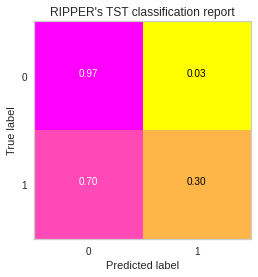

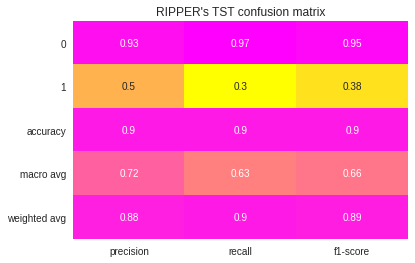

In [105]:
# performance plots
cm = confusion_matrix(y_ts, y_pred_ord)
plot_confusion_matrix(cm, [0, 1], True)
plot_classification_report(y_ts, y_pred_ord)

<Figure size 576x360 with 0 Axes>

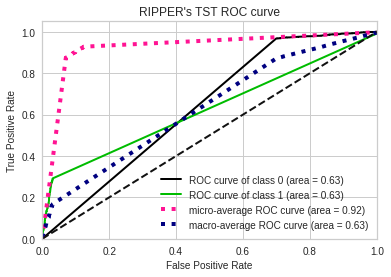

<Figure size 576x360 with 0 Axes>

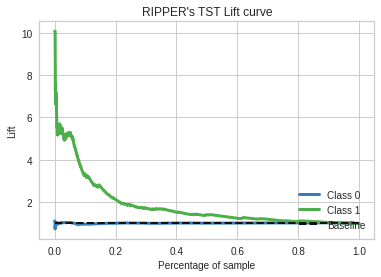

In [107]:
plot_roc_curve(y_ts, y_prob_ord)
plot_lift_curve_curve(y_ts, y_prob_ord)

In [112]:
# plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), model)  # passing random scaler

In [111]:
# plot_learning_curve(X_tr, y_tr, model, v_or_t_flag)

<h2>Learning curves </h2>

This plotting is done at the end of the notebook, beacuse for some reason yellowbrick library overwrite scikitplot.

<h6>Saving best model on file</h6>

In [27]:
import pickle

model_info = {'model_name': 'Plain',
              # 'params': params_tst,
              'params': {'model__prune_size': 0.1, 'model__n_discretize_bins': 4, 'model__k': 1} 
              'tuned_model': model,
              'y_pred': y_pred,
              'y_prob': y_prob,
              # 'best_features': best_features,
              # 'best_features_scores': best_features_scores
             }

with open('pickle/' + model_name + '.pickle', 'wb') as handle:
    pickle.dump(model_info, handle, protocol=pickle.HIGHEST_PROTOCOL)